# [1] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.


## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

# Task to be performed:
1. Apply the random forest Classifier
2. Take any two hyperparameters and tune them
3. As we are having two hyperparameters to tune for representing the error plot you can use heat maps,example like this, rows representing one hyperparameter and columns representing other hyperparameter and the values in each representing the error metric value.
4. Get important features and represent them in a word cloud.

In [1]:
import numpy as np 
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score 
from sklearn.metrics import accuracy_score,precision_score,recall_score,classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import sqlite3

C:\Users\manish dogra\Documents\anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
con = sqlite3.connect("./amazon-fine-food-reviews/database.sqlite")
data = pd.read_sql_query('''
SELECT *
FROM REVIEWS
WHERE SCORE != 3''', con)
data.shape

(525814, 10)

# Data Cleaning

In [3]:
data = data[data.HelpfulnessNumerator <= data.HelpfulnessDenominator]
data.shape

(525812, 10)

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [4]:
data['Score'] = data["Score"].apply(lambda x: "positive" if x > 3 else "negative")
sorted_data = data.sort_values('ProductId',axis = 0, inplace = False, kind = 'quicksort',ascending = True)
sorted_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138693,150511,0006641040,A1C9K534BCI9GO,Laura Purdie Salas,0,0,positive,1344211200,Charming and childlike,"A charming, rhyming book that describes the ci..."
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,negative,1129507200,awesome book poor size,This is one of the best children's books ever ...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,positive,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books..."
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138705,150523,0006641040,A2P4F2UO0UMP8C,"Elizabeth A. Curry ""Lovely Librarian""",0,0,positive,1096675200,MMMM chicken soup....,Summary: A young boy describes the usefulness...


In [5]:
filtered_data = sorted_data.drop_duplicates(subset = {'UserId','ProfileName','Time'} ,keep = 'first', inplace = False)
filtered_data.shape

(328770, 10)

In [6]:
#filtered_data['Score'].value_counts()
final = filtered_data.copy()

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\manish
[nltk_data]     dogra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
stop = set(stopwords.words("english"))
st = PorterStemmer()
st.stem('burned')

'burn'

##  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [9]:
def cleanhtml(sent):
    cleanr = re.compile('<.*?>')
    cleaned = re.sub(cleanr,' ',sent)
    return cleaned
def cleanpunc(sent):
    clean = re.sub(r'[?|!|$|#|\'|"|:]',r'',sent)
    clean = re.sub(r'[,|(|)|.|\|/]',r' ',clean)
    return clean

In [10]:
i=0
all_positive_reviews =[]
all_negative_reviews = []
final_string = []
stem_data = " "
for p in final['Text'].values:
    filtered_sens = []#filtered word
    p = cleanhtml(p)
    for w in p.split():
       # print(w)
        punc = cleanpunc(w)
        for s in punc.split():
            #print(w)
            if (s.isalpha()) & (len(s)>2):
                if s.lower() not in stop:
                    stem_data = (st.stem(s.lower())).encode('utf8')
                    #can we use lemmatizer and stemming altogether??
                    filtered_sens.append(stem_data)
                    if (final['Score'].values)[i] == 'positive':
                        all_positive_reviews.append(stem_data)
                    if (final['Score'].values)[i] == 'negative':
                        all_negative_reviews.append(stem_data)
                else:
                    continue
            else:
                continue
    #print(filtered_sens)
    str1 = b" ".join(filtered_sens)
    #print(str1)
    final_string.append(str1)
    i+=1

In [11]:
final['CleanedText'] = final_string
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138693,150511,0006641040,A1C9K534BCI9GO,Laura Purdie Salas,0,0,positive,1344211200,Charming and childlike,"A charming, rhyming book that describes the ci...",b'charm rhyme book describ circumst eat dont c...
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,negative,1129507200,awesome book poor size,This is one of the best children's books ever ...,b'one best children book ever written mini ver...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,positive,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books...",b'daughter love realli rosi book introduc real...
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
138705,150523,0006641040,A2P4F2UO0UMP8C,"Elizabeth A. Curry ""Lovely Librarian""",0,0,positive,1096675200,MMMM chicken soup....,Summary: A young boy describes the usefulness...,b'summari young boy describ use chicken soup r...


In [12]:
final = final.sort_values('Time',axis= 0,inplace = False , na_position = 'last',ascending = True)
X = final['CleanedText'].values
X = X[:100000]
y = final['Score'].values
y = y[:100000]

In [13]:
X_train ,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,stratify = y)

In [14]:
count_vect = CountVectorizer()
bow_train = count_vect.fit_transform(X_train)
bow_test = count_vect.transform(X_test)

# Random Forest on Bow

In [15]:
param_grid = {'n_estimators': [8, 16, 32, 64, 100, 200],'max_depth': [2, 5, 7, 9]}
gd = GridSearchCV(RandomForestClassifier(class_weight = 'balanced'),param_grid,cv = 5,scoring = 'accuracy')
gd.fit(bow_train,y_train)
print(gd.best_estimator_)
pred = gd.predict(bow_test)
acc = accuracy_score(y_test,pred)
print('Accuracy is',acc*100)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=9, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy is 87.3166666667


C:\Users\manish dogra\Documents\anaconda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


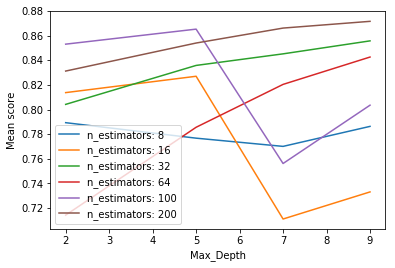

In [16]:
n_est = [8, 16, 32, 64, 100, 200]
max_dep = [2, 5, 7, 9]
scores = [x[1] for x in gd.grid_scores_]
scores = np.array(scores).reshape(len(n_est), len(max_dep))

for ind, i in enumerate(n_est):
    plt.plot(max_dep, scores[ind], label='n_estimators: ' + str(i))
plt.legend()
plt.xlabel('Max_Depth')
plt.ylabel('Mean score')
plt.show()


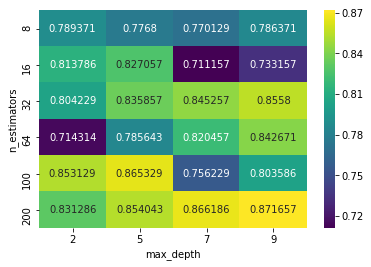

In [17]:
heat = pd.DataFrame(scores,columns = [2,5,7,9],index = [8, 16, 32, 64, 100, 200])
sns.heatmap(heat,annot = True,fmt="g", cmap='viridis')
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.show()

In [18]:
from sklearn.metrics import recall_score , precision_score , roc_auc_score ,roc_curve
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))
print('\n')
print('Recall for positive',recall_score(y_test,pred,pos_label = 'positive'))
print('Recall for negative',recall_score(y_test,pred,pos_label = 'negative'))
print('\n')
print('Precision for postive',precision_score(y_test,pred,pos_label = 'positive'))
print('Precision for negative',precision_score(y_test,pred,pos_label = 'negative'))

             precision    recall  f1-score   support

   negative       0.50      0.73      0.59      3811
   positive       0.96      0.89      0.92     26189

avg / total       0.90      0.87      0.88     30000



Recall for positive 0.894154034136
Recall for negative 0.728942534768


Precision for postive 0.957750511247
Precision for negative 0.500540540541


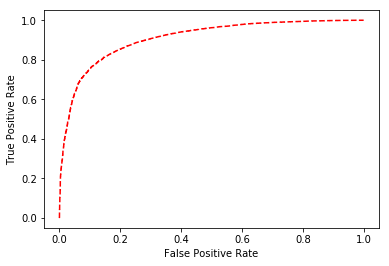

In [19]:
change = lambda x : 1 if x == 'positive' else 0
y_true = np.array([change(x) for x in y_test])
y_pred = gd.predict_proba(bow_test)[:,1]
fpr,tpr,thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

ROC Score 0.908012876625


[[ 2778  1033]
 [ 2772 23417]]


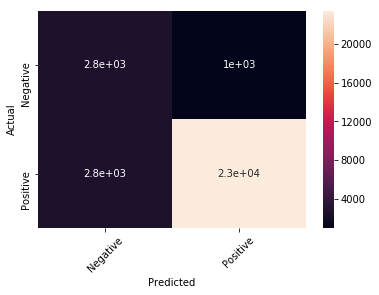

In [20]:
print('ROC Score',roc_auc_score(y_true,y_pred))
print('\n')
confusion = confusion_matrix(y_test , pred)
print(confusion)
df_cm = pd.DataFrame(confusion , index = ['Negative','Positive'])
sns.heatmap(df_cm ,annot = True)
plt.xticks([0.5,1.5],['Negative','Positive'],rotation = 45)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Top 10 important features of Random Forest


In [23]:
index = gd.best_estimator_.feature_importances_.argsort()[::-1]
top_10 = np.take(count_vect.get_feature_names(),index)
print(top_10)

['best' 'worst' 'disappoint' ..., 'peco' 'pecorino' 'aaa']


# GBDT on Bow

In [24]:
para_grid = {'n_estimators': [8, 16, 32, 64, 100, 200],'max_depth': [10,20]}
ggd = GridSearchCV(GradientBoostingClassifier(),para_grid,cv = 5,scoring = 'accuracy')
ggd.fit(bow_train,y_train)
print(ggd.best_estimator_)
pred = ggd.predict(bow_test)
acc = accuracy_score(y_test,pred)
print('Accuracy is',acc*100)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
Accuracy is 91.21


C:\Users\manish dogra\Documents\anaconda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


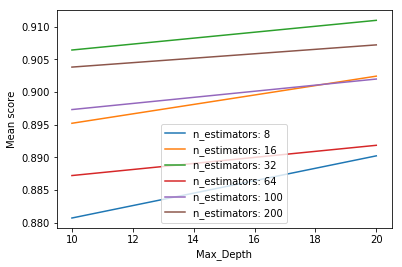

In [25]:
n_est = [8, 16, 32, 64, 100, 200]
max_dep = [ 10,20]
scores = [x[1] for x in ggd.grid_scores_]
scores = np.array(scores).reshape(len(n_est), len(max_dep))

for ind, i in enumerate(n_est):
    plt.plot(max_dep, scores[ind], label='n_estimators: ' + str(i))
plt.legend()
plt.xlabel('Max_Depth')
plt.ylabel('Mean score')
plt.show()

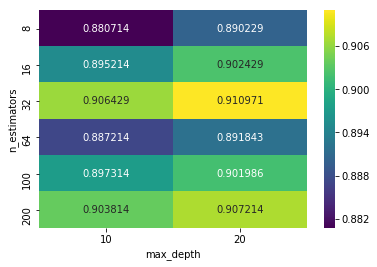

In [26]:
heat = pd.DataFrame(scores,columns = [ 10,20],index = [8, 16, 32, 64, 100, 200])
sns.heatmap(heat,annot = True,fmt="g", cmap='viridis')
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.show()

In [27]:
from sklearn.metrics import recall_score , precision_score , roc_auc_score ,roc_curve
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))
print('\n')
print('Recall for positive',recall_score(y_test,pred,pos_label = 'positive'))
print('Recall for negative',recall_score(y_test,pred,pos_label = 'negative'))
print('\n')
print('Precision for postive',precision_score(y_test,pred,pos_label = 'positive'))
print('Precision for negative',precision_score(y_test,pred,pos_label = 'negative'))

             precision    recall  f1-score   support

   negative       0.80      0.41      0.54      3811
   positive       0.92      0.98      0.95     26189

avg / total       0.90      0.91      0.90     30000



Recall for positive 0.984764595823
Recall for negative 0.412752558384


Precision for postive 0.920151277294
Precision for negative 0.797667342799


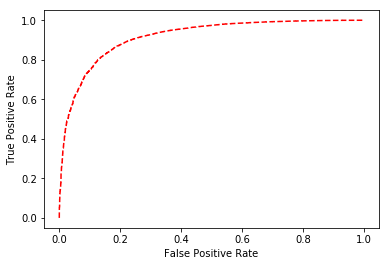

In [28]:
change = lambda x : 1 if x == 'positive' else 0
y_true = np.array([change(x) for x in y_test])
y_pred = ggd.predict_proba(bow_test)[:,1]
fpr,tpr,thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

ROC Score 0.916096376061


[[ 1573  2238]
 [  399 25790]]


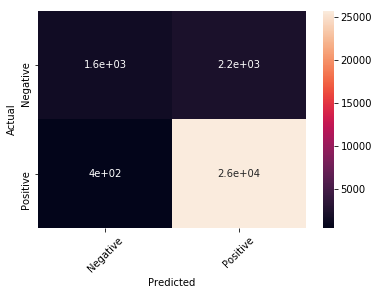

In [29]:
print('ROC Score',roc_auc_score(y_true,y_pred))
print('\n')
confusion = confusion_matrix(y_test , pred)
print(confusion)
df_cm = pd.DataFrame(confusion , index = ['Negative','Positive'])
sns.heatmap(df_cm ,annot = True)
plt.xticks([0.5,1.5],['Negative','Positive'],rotation = 45)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Top 10 important features of GBDT

In [31]:
index = ggd.best_estimator_.feature_importances_.argsort()[::-1]
top_10 = np.take(count_vect.get_feature_names(),index)
print(top_10)

['great' 'disappoint' 'good' ..., 'parish' 'parisian' 'aaa']


# Random Forest on Tfidf

In [32]:
tfidf_vect = TfidfVectorizer()
tfidf_train = tfidf_vect.fit_transform (X_train)
tfidf_test = tfidf_vect.transform(X_test)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean = False)
X_tr = sc.fit_transform(tfidf_train)
X_te = sc.transform(tfidf_test)
gd_tf = GridSearchCV(RandomForestClassifier(class_weight = 'balanced'),para_grid,cv = 5,scoring = 'accuracy')
gd_tf.fit(X_tr,y_train)
print(gd_tf.best_params_)
pred = gd_tf.predict(X_te)
acc = accuracy_score(y_test,pred)
print('Accuracy is',acc*100)

{'max_depth': 20, 'n_estimators': 200}
Accuracy is 89.4366666667


C:\Users\manish dogra\Documents\anaconda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


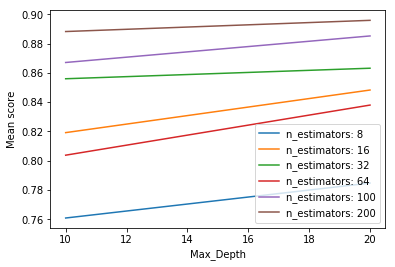

In [33]:
n_est = [8, 16, 32, 64, 100, 200]
max_dep = [ 10,20]
scores = [x[1] for x in gd_tf.grid_scores_]
scores = np.array(scores).reshape(len(n_est), len(max_dep))

for ind, i in enumerate(n_est):
    plt.plot(max_dep, scores[ind], label='n_estimators: ' + str(i))
plt.legend()
plt.xlabel('Max_Depth')
plt.ylabel('Mean score')
plt.show()

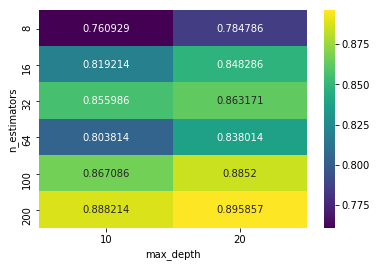

In [34]:
heat = pd.DataFrame(scores,columns = [ 10,20],index = [8, 16, 32, 64, 100, 200])
sns.heatmap(heat,annot = True,fmt="g", cmap='viridis')
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.show()

In [35]:
from sklearn.metrics import recall_score , precision_score , roc_auc_score ,roc_curve
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))
print('\n')
print('Recall for positive',recall_score(y_test,pred,pos_label = 'positive'))
print('Recall for negative',recall_score(y_test,pred,pos_label = 'negative'))
print('\n')
print('Precision for postive',precision_score(y_test,pred,pos_label = 'positive'))
print('Precision for negative',precision_score(y_test,pred,pos_label = 'negative'))

             precision    recall  f1-score   support

   negative       0.57      0.70      0.63      3811
   positive       0.96      0.92      0.94     26189

avg / total       0.91      0.89      0.90     30000



Recall for positive 0.922295620299
Recall for negative 0.702440304382


Precision for postive 0.955156596014
Precision for negative 0.568123938879


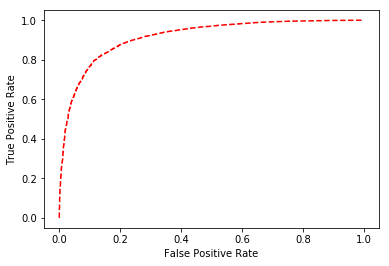

In [36]:
change = lambda x : 1 if x == 'positive' else 0
y_true = np.array([change(x) for x in y_test])
y_pred = gd_tf.predict_proba(X_te)[:,1]
fpr,tpr,thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

ROC Score 0.916330344306


[[ 2677  1134]
 [ 2035 24154]]


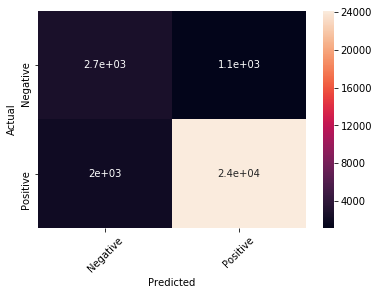

In [37]:
print('ROC Score',roc_auc_score(y_true,y_pred))
print('\n')
confusion = confusion_matrix(y_test , pred)
print(confusion)
df_cm = pd.DataFrame(confusion , index = ['Negative','Positive'])
sns.heatmap(df_cm ,annot = True)
plt.xticks([0.5,1.5],['Negative','Positive'],rotation = 45)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Top 10 important features of Random Forest


In [40]:
index = gd_tf.best_estimator_.feature_importances_.argsort()[::-1]
top_10 = np.take(tfidf_vect.get_feature_names(),index)
print(top_10)

['great' 'best' 'love' ..., 'orgi' 'orgini' 'aaa']


# GBDT on Tfidf

In [41]:
para_grid = {'n_estimators': [8, 16, 32, 64, 100, 200],'max_depth': [2, 5, 7, 9]}
ggd_tf = GridSearchCV(GradientBoostingClassifier(),para_grid,cv = 3,scoring = 'accuracy')
ggd_tf.fit(X_tr,y_train)
print(ggd_tf.best_params_)
pred = ggd_tf.predict(X_te)
acc = accuracy_score(y_test,pred)
print('Accuracy is',acc*100)

{'max_depth': 9, 'n_estimators': 200}
Accuracy is 91.1233333333


C:\Users\manish dogra\Documents\anaconda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


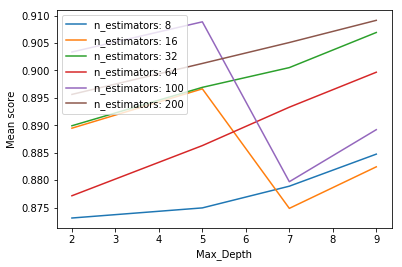

In [42]:
n_est = [8, 16, 32, 64, 100, 200]
max_dep =[2, 5, 7, 9]
scores = [x[1] for x in ggd_tf.grid_scores_]
scores = np.array(scores).reshape(len(n_est), len(max_dep))

for ind, i in enumerate(n_est):
    plt.plot(max_dep, scores[ind], label='n_estimators: ' + str(i))
plt.legend()
plt.xlabel('Max_Depth')
plt.ylabel('Mean score')
plt.show()

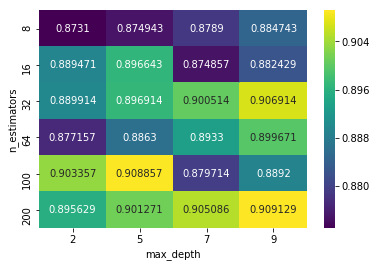

In [43]:
heat = pd.DataFrame(scores,columns = [2, 5, 7, 9],index = [8, 16, 32, 64, 100, 200])
sns.heatmap(heat,annot = True,fmt="g", cmap='viridis')
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.show()

In [44]:
from sklearn.metrics import recall_score , precision_score , roc_auc_score ,roc_curve
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))
print('\n')
print('Recall for positive',recall_score(y_test,pred,pos_label = 'positive'))
print('Recall for negative',recall_score(y_test,pred,pos_label = 'negative'))
print('\n')
print('Precision for postive',precision_score(y_test,pred,pos_label = 'positive'))
print('Precision for negative',precision_score(y_test,pred,pos_label = 'negative'))

             precision    recall  f1-score   support

   negative       0.81      0.40      0.53      3811
   positive       0.92      0.99      0.95     26189

avg / total       0.90      0.91      0.90     30000



Recall for positive 0.986177402726
Recall for negative 0.396221464183


Precision for postive 0.918195392491
Precision for negative 0.806623931624


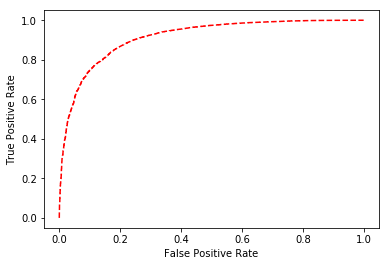

In [45]:
change = lambda x : 1 if x == 'positive' else 0
y_true = np.array([change(x) for x in y_test])
y_pred = ggd_tf.predict_proba(X_te)[:,1]
fpr,tpr,thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

ROC Score 0.913903122267


[[ 1510  2301]
 [  362 25827]]


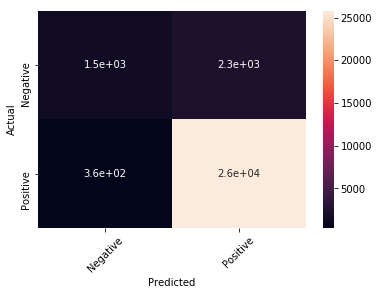

In [46]:
print('ROC Score',roc_auc_score(y_true,y_pred))
print('\n')
confusion = confusion_matrix(y_test , pred)
print(confusion)
df_cm = pd.DataFrame(confusion , index = ['Negative','Positive'])
sns.heatmap(df_cm ,annot = True)
plt.xticks([0.5,1.5],['Negative','Positive'],rotation = 45)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Top 10 important features of GBDT


In [47]:
index = ggd_tf.best_estimator_.feature_importances_.argsort()[::-1]
top_10 = np.take(tfidf_vect.get_feature_names(),index)
print(top_10)

['great' 'love' 'disappoint' ..., 'perchanc' 'perchas' 'aaa']


In [39]:
list_of_sent_train = []
for i in X_train:
    sent = []
    for word in i.split():
        sent.append(word.decode('utf-8'))
    list_of_sent_train.append(sent)

In [40]:
from gensim.models import Word2Vec
w2v_model = Word2Vec(list_of_sent_train,min_count = 5,size = 50,workers = 4)
sent_vectors_train = []
for sent in list_of_sent_train:
    sent_vec = np.zeros(50)
    cnt_word = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_word += 1
        except:
            pass
    sent_vec /= cnt_word
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))

C:\Users\manish dogra\Documents\anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


70000


In [41]:
list_of_sent_test = []
for i in X_test:
    sent = []
    for word in i.split():
        sent.append(word.decode('utf-8'))
    list_of_sent_test.append(sent)

In [42]:
import warnings
warnings.filterwarnings("ignore")
from gensim.models import Word2Vec
w2v_model = Word2Vec(list_of_sent_test,min_count = 5,size = 50,workers = 4)
sent_vectors_test = []
for sent in list_of_sent_test:
    sent_vec = np.zeros(50)
    cnt_word = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_word += 1
        except:
            pass
    sent_vec /= cnt_word
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))

30000


In [43]:
np.where(np.isnan(sent_vectors_test))

(array([], dtype=int64), array([], dtype=int64))

# Random Forest on Avg W2vec

In [44]:
para_grid = {'n_estimators': [8, 16, 32, 64, 100, 200],'max_depth': [10,20]}
sc = StandardScaler()
w2v_train = sc.fit_transform(sent_vectors_train)
w2v_test = sc.transform(sent_vectors_test)
gd_w2v = GridSearchCV(RandomForestClassifier(class_weight = 'balanced'),para_grid,cv = 5,scoring = 'accuracy')
gd_w2v.fit(w2v_train,y_train)
print(gd_w2v.best_params_)
pred = gd_w2v.predict(w2v_test)
acc = accuracy_score(y_test,pred)
print('Accuracy is',acc*100)

{'max_depth': 20, 'n_estimators': 200}
Accuracy is 87.3


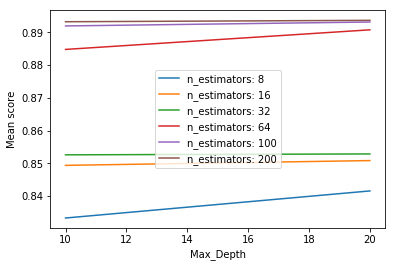

In [45]:
n_est = [8, 16, 32, 64, 100, 200]
max_dep = [ 10,20]
scores = [x[1] for x in gd_w2v.grid_scores_]
scores = np.array(scores).reshape(len(n_est), len(max_dep))

for ind, i in enumerate(n_est):
    plt.plot(max_dep, scores[ind], label='n_estimators: ' + str(i))
plt.legend()
plt.xlabel('Max_Depth')
plt.ylabel('Mean score')
plt.show()

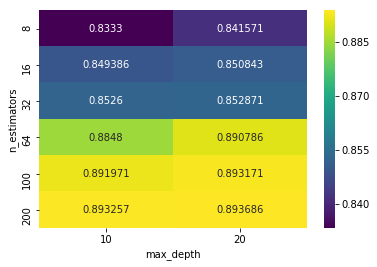

In [46]:
heat = pd.DataFrame(scores,columns = [ 10,20],index = [8, 16, 32, 64, 100, 200])
sns.heatmap(heat,annot = True,fmt="g", cmap='viridis')
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.show()

In [47]:
from sklearn.metrics import recall_score , precision_score , roc_auc_score ,roc_curve
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))
print('\n')
print('Recall for positive',recall_score(y_test,pred,pos_label = 'positive'))
print('Recall for negative',recall_score(y_test,pred,pos_label = 'negative'))
print('\n')
print('Precision for postive',precision_score(y_test,pred,pos_label = 'positive'))
print('Precision for negative',precision_score(y_test,pred,pos_label = 'negative'))

             precision    recall  f1-score   support

   negative       0.53      0.00      0.00      3811
   positive       0.87      1.00      0.93     26189

avg / total       0.83      0.87      0.81     30000



Recall for positive 0.999732712207
Recall for negative 0.00209918656521


Precision for postive 0.873169918292
Precision for negative 0.533333333333


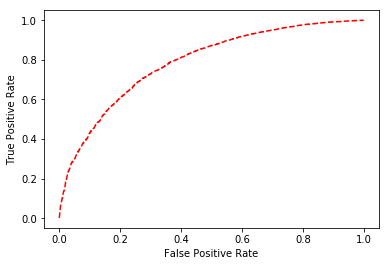

In [48]:
change = lambda x : 1 if x == 'positive' else 0
y_true = np.array([change(x) for x in y_test])
y_pred = gd_w2v.predict_proba(w2v_test)[:,1]
fpr,tpr,thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

ROC Score 0.787019246555


[[    8  3803]
 [    7 26182]]


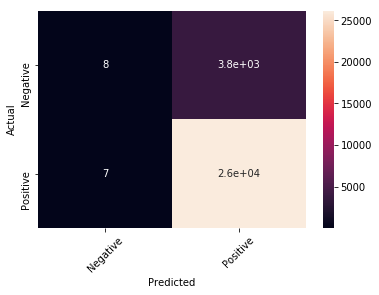

In [49]:
print('ROC Score',roc_auc_score(y_true,y_pred))
print('\n')
confusion = confusion_matrix(y_test , pred)
print(confusion)
df_cm = pd.DataFrame(confusion , index = ['Negative','Positive'])
sns.heatmap(df_cm ,annot = True)
plt.xticks([0.5,1.5],['Negative','Positive'],rotation = 45)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# GBDT on Avg W2vec

In [50]:
ggd_w2v = GridSearchCV(GradientBoostingClassifier(),para_grid,cv = 5,scoring = 'accuracy')
ggd_w2v.fit(w2v_train,y_train)
print(ggd_w2v.best_params_)
pred = ggd_w2v.predict(w2v_test)
acc = accuracy_score(y_test,pred)
print('Accuracy is',acc*100)

{'max_depth': 10, 'n_estimators': 200}
Accuracy is 87.5166666667


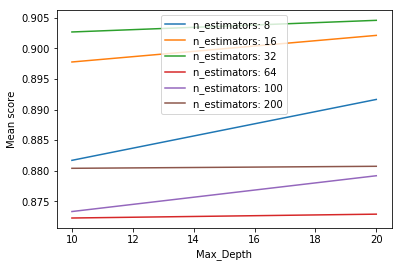

In [51]:
n_est = [8, 16, 32, 64, 100, 200]
max_dep = [ 10,20]
scores = [x[1] for x in ggd_w2v.grid_scores_]
scores = np.array(scores).reshape(len(n_est), len(max_dep))

for ind, i in enumerate(n_est):
    plt.plot(max_dep, scores[ind], label='n_estimators: ' + str(i))
plt.legend()
plt.xlabel('Max_Depth')
plt.ylabel('Mean score')
plt.show()

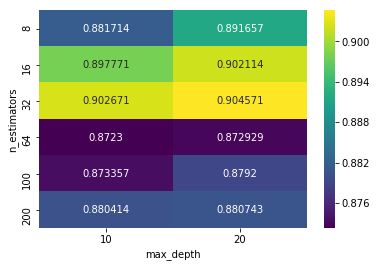

In [52]:
heat = pd.DataFrame(scores,columns = [ 10,20],index = [8, 16, 32, 64, 100, 200])
sns.heatmap(heat,annot = True,fmt="g", cmap='viridis')
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.show()

In [53]:
from sklearn.metrics import recall_score , precision_score , roc_auc_score ,roc_curve
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))
print('\n')
print('Recall for positive',recall_score(y_test,pred,pos_label = 'positive'))
print('Recall for negative',recall_score(y_test,pred,pos_label = 'negative'))
print('\n')
print('Precision for postive',precision_score(y_test,pred,pos_label = 'positive'))
print('Precision for negative',precision_score(y_test,pred,pos_label = 'negative'))

             precision    recall  f1-score   support

   negative       0.57      0.07      0.13      3811
   positive       0.88      0.99      0.93     26189

avg / total       0.84      0.88      0.83     30000



Recall for positive 0.992019550193
Recall for negative 0.072159538179


Precision for postive 0.880200569183
Precision for negative 0.568181818182


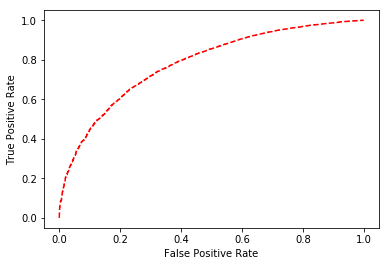

In [54]:
change = lambda x : 1 if x == 'positive' else 0
y_true = np.array([change(x) for x in y_test])
y_pred = ggd_w2v.predict_proba(w2v_test)[:,1]
fpr,tpr,thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

ROC Score 0.781370669074


[[  275  3536]
 [  209 25980]]


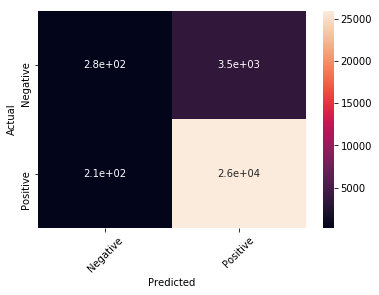

In [55]:
print('ROC Score',roc_auc_score(y_true,y_pred))
print('\n')
confusion = confusion_matrix(y_test , pred)
print(confusion)
df_cm = pd.DataFrame(confusion , index = ['Negative','Positive'])
sns.heatmap(df_cm ,annot = True)
plt.xticks([0.5,1.5],['Negative','Positive'],rotation = 45)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [56]:
tf_idf_feat = tfidf_vect.get_feature_names()
tfidf_sent_vec_train = []
row = 0
for sent in list_of_sent_train:
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tfidf_train[row,tf_idf_feat.index(word)]
            sent_vec += (vec*tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec/= weight_sum
    tfidf_sent_vec_train.append(sent_vec)
    row += 1


In [57]:
tf_idf_feat = tfidf_vect.get_feature_names()
tfidf_sent_vec_test = []
row = 0
for sent in list_of_sent_test:
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tfidf_test[row,tf_idf_feat.index(word)]
            sent_vec += (vec*tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec/= weight_sum
    tfidf_sent_vec_test.append(sent_vec)
    row += 1


In [58]:
np.where(np.isnan(tfidf_sent_vec_train))

(array([16718, 16718, 16718, 16718, 16718, 16718, 16718, 16718, 16718,
        16718, 16718, 16718, 16718, 16718, 16718, 16718, 16718, 16718,
        16718, 16718, 16718, 16718, 16718, 16718, 16718, 16718, 16718,
        16718, 16718, 16718, 16718, 16718, 16718, 16718, 16718, 16718,
        16718, 16718, 16718, 16718, 16718, 16718, 16718, 16718, 16718,
        16718, 16718, 16718, 16718, 16718], dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], dtype=int64))

In [61]:
 y_tr = y_train
del tfidf_sent_vec_train[16718]
y_train = np.delete(y_train,16718)

# Random Forest on Tfidf W2vec

In [62]:
sc =  StandardScaler()
tfidf_w2v_train = sc.fit_transform(tfidf_sent_vec_train)
tfidf_w2v_test = sc.transform(tfidf_sent_vec_test)
gd_wtf = GridSearchCV(RandomForestClassifier(class_weight = 'balanced'),para_grid,cv = 5,scoring = 'accuracy')
gd_wtf.fit(tfidf_w2v_train,y_train)
print(gd_wtf.best_params_)
pred = gd_wtf.predict(tfidf_w2v_test)
acc = accuracy_score(y_test,pred)
print('Accuracy is',acc*100)

{'max_depth': 20, 'n_estimators': 200}
Accuracy is 88.7066666667


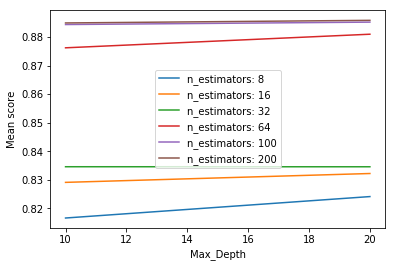

In [63]:
n_est = [8, 16, 32, 64, 100, 200]
max_dep = [ 10,20]
scores = [x[1] for x in gd_wtf.grid_scores_]
scores = np.array(scores).reshape(len(n_est), len(max_dep))

for ind, i in enumerate(n_est):
    plt.plot(max_dep, scores[ind], label='n_estimators: ' + str(i))
plt.legend()
plt.xlabel('Max_Depth')
plt.ylabel('Mean score')
plt.show()

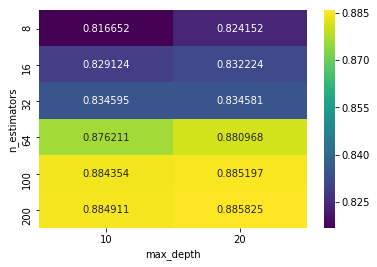

In [64]:
heat = pd.DataFrame(scores,columns = [ 10,20],index = [8, 16, 32, 64, 100, 200])
sns.heatmap(heat,annot = True,fmt="g", cmap='viridis')
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.show()

In [65]:
from sklearn.metrics import recall_score , precision_score , roc_auc_score ,roc_curve
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))
print('\n')
print('Recall for positive',recall_score(y_test,pred,pos_label = 'positive'))
print('Recall for negative',recall_score(y_test,pred,pos_label = 'negative'))
print('\n')
print('Precision for postive',precision_score(y_test,pred,pos_label = 'positive'))
print('Precision for negative',precision_score(y_test,pred,pos_label = 'negative'))

             precision    recall  f1-score   support

   negative       0.62      0.28      0.38      3811
   positive       0.90      0.98      0.94     26189

avg / total       0.87      0.89      0.87     30000



Recall for positive 0.975714994845
Recall for negative 0.277879821569


Precision for postive 0.902773361597
Precision for negative 0.624778761062


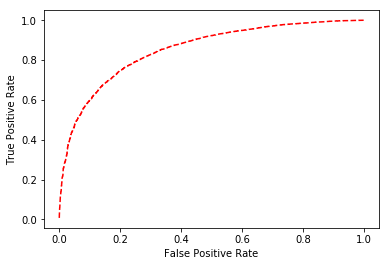

In [66]:
change = lambda x : 1 if x == 'positive' else 0
y_true = np.array([change(x) for x in y_test])
y_pred = gd_wtf.predict_proba(tfidf_w2v_test)[:,1]
fpr,tpr,thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

ROC Score 0.852560674063


[[ 1059  2752]
 [  636 25553]]


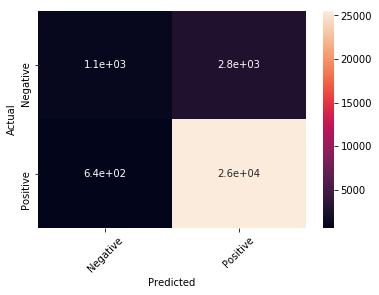

In [67]:
print('ROC Score',roc_auc_score(y_true,y_pred))
print('\n')
confusion = confusion_matrix(y_test , pred)
print(confusion)
df_cm = pd.DataFrame(confusion , index = ['Negative','Positive'])
sns.heatmap(df_cm ,annot = True)
plt.xticks([0.5,1.5],['Negative','Positive'],rotation = 45)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# GBDT on Tfidf W2vec

In [68]:
ggd_wtf = GridSearchCV(GradientBoostingClassifier(),para_grid,cv = 3,scoring = 'accuracy')
ggd_wtf.fit(tfidf_w2v_train,y_train)
print(ggd_wtf.best_params_)
pred = ggd_wtf.predict(tfidf_w2v_test)
acc = accuracy_score(y_test,pred)
print('Accuracy is',acc*100)

{'max_depth': 10, 'n_estimators': 200}
Accuracy is 89.1566666667


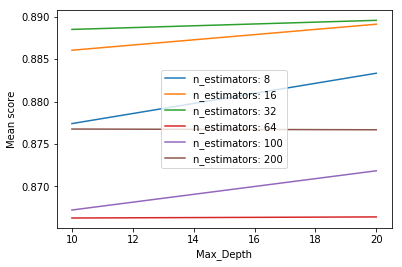

In [69]:
n_est = [8, 16, 32, 64, 100, 200]
max_dep = [ 10,20]
scores = [x[1] for x in ggd_wtf.grid_scores_]
scores = np.array(scores).reshape(len(n_est), len(max_dep))

for ind, i in enumerate(n_est):
    plt.plot(max_dep, scores[ind], label='n_estimators: ' + str(i))
plt.legend()
plt.xlabel('Max_Depth')
plt.ylabel('Mean score')
plt.show()

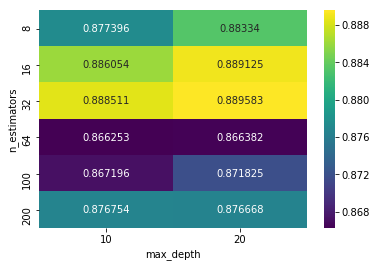

In [70]:
heat = pd.DataFrame(scores,columns = [ 10,20],index = [8, 16, 32, 64, 100, 200])
sns.heatmap(heat,annot = True,fmt="g", cmap='viridis')
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.show()

In [71]:
from sklearn.metrics import recall_score , precision_score , roc_auc_score ,roc_curve
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))
print('\n')
print('Recall for positive',recall_score(y_test,pred,pos_label = 'positive'))
print('Recall for negative',recall_score(y_test,pred,pos_label = 'negative'))
print('\n')
print('Precision for postive',precision_score(y_test,pred,pos_label = 'positive'))
print('Precision for negative',precision_score(y_test,pred,pos_label = 'negative'))

             precision    recall  f1-score   support

   negative       0.66      0.30      0.41      3811
   positive       0.91      0.98      0.94     26189

avg / total       0.87      0.89      0.87     30000



Recall for positive 0.977700561304
Recall for negative 0.299658882183


Precision for postive 0.905602320153
Precision for negative 0.661645422943


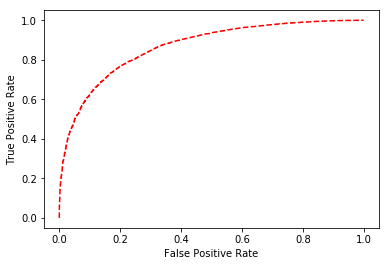

In [72]:
change = lambda x : 1 if x == 'positive' else 0
y_true = np.array([change(x) for x in y_test])
y_pred = ggd_wtf.predict_proba(tfidf_w2v_test)[:,1]
fpr,tpr,thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

ROC Score 0.866378256623


[[ 1142  2669]
 [  584 25605]]


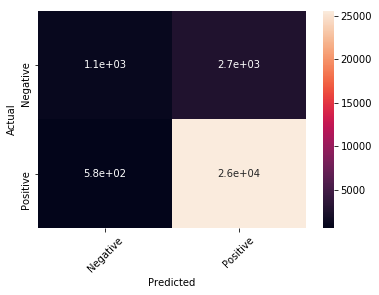

In [73]:
print('ROC Score',roc_auc_score(y_true,y_pred))
print('\n')
confusion = confusion_matrix(y_test , pred)
print(confusion)
df_cm = pd.DataFrame(confusion , index = ['Negative','Positive'])
sns.heatmap(df_cm ,annot = True)
plt.xticks([0.5,1.5],['Negative','Positive'],rotation = 45)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Result 
<h3>RF on BOW</h3>
* Optimal max_depth = 9
* n_estimator = 200
* Accuracy = 86.89
* Precision = 0.96(positive), 0.49(negative)
* Recall = 0.89 ,0.73
* AUC = 0.905
* TN = 2790
* TP = 23278
<h3>GBDT on BOW</h3>
* Optimal max_depth = 10
* n_estimator = 200
* Accuracy = 91.38
* Precision = 0.92(positive), 0.82(negative)
* Recall = 0.99 ,0.41
* AUC = 0.918
* TN = 1579
* TP = 25837
<h3>R.F on Tfidf</h3>
* Optimal max_depth = 20
* n_estimator = 200
* Accuracy = 89.34
* Precision = 0.95(positive), 0.57(negative)
* Recall = 0.92 ,0.69
* AUC = 0.916
* TN = 2636
* TP = 24167
<h3>GBDT on Tfidf</h3>
* Optimal max_depth = 9
* n_estimator = 200
* Accuracy = 91.23
* Precision = 0.92(positive), 0.82(negative)
* Recall = 0.99 ,0.40
* AUC = 0.915
* TN = 1513
* TP = 25856
<h3>R.F on Avg-w2vec</h3>
* Optimal max_depth = 20
* n_estimator = 200
* Accuracy = 87.3
* Precision = 0.87(positive), 0.53(negative)
* Recall = 1.0 ,0.0
* AUC = 0.787
* TN = 8
* TP = 26182
<h3>GBDT on Avg-w2vec</h3>
* Optimal max_depth = 10
* n_estimator = 200
* Accuracy = 87.5
* Precision = 0.88(positive), 0.57(negative)
* Recall = 0.99 ,0.07
* AUC = 0.781
* TN = 275
* TP = 25980
<h3>R.F on Tfidf-w2vec</h3>
* Optimal max_depth = 20
* n_estimator = 200
* Accuracy = 88.70
* Precision = 0.90(positive), 0.62(negative)
* Recall = 0.98 ,0.28
* AUC = 0.85
* TN = 1059
* TP = 25553
<h3>GBDT on Tfidf-w2vec</h3>
* Optimal max_depth = 10
* n_estimator = 200
* Accuracy = 89.156
* Precision = 0.91(positive), 0.66(negative)
* Recall = 0.98 ,0.30
* AUC = 0.866
* TN = 1142
* TP = 25605